In [1]:
import os
import math
import tarfile
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader

<b>Steps:</b>

    1. Download Image dataset
    2. Visualize the dataset
    3. Preprocessing:
        a) Split dataset
        b) Image augmentation
        c) Data generator
    4. Model Architecture
        a) Network
        b) Loss Function
    5. Train model
    6. Evaluate model
        a) Plot Loss and Accuracy
    7. Predict on test dataset

In [9]:
class CosFace(torch.nn.Module):
    def __init__(self, s=64.0, m=0.40):
        super(CosFace, self).__init__()
        self.s = s
        self.m = m

    def forward(self, logits: torch.Tensor, labels: torch.Tensor):
        index = torch.where(labels != -1)[0]
        target_logit = logits[index, labels[index].view(-1)]
        final_target_logit = target_logit - self.m
        logits[index, labels[index].view(-1)] = final_target_logit
        logits = logits * self.s
        return logits

In [89]:
class CosFace(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.35):
        super(CosFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.kernel = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.normal_(self.kernel, std=0.01)

    def forward(self, embbedings, label):
        embbedings = l2_norm(embbedings, axis=1)
        kernel_norm = l2_norm(self.kernel, axis=0)
        cos_theta = torch.mm(embbedings, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        index = torch.where(label != -1)[0]
        m_hot = torch.zeros(index.size()[0], cos_theta.size()[1])
        m_hot.scatter_(1, label[index, None], self.m)
        cos_theta[index] -= m_hot
        ret = cos_theta * self.s
        return ret

In [93]:
aa = CosFace(a, b)

TypeError: new() received an invalid combination of arguments - got (Tensor, Tensor), but expected one of:
 * (*, torch.device device)
      didn't match because some of the arguments have invalid types: (!Tensor!, !Tensor!)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


In [149]:
input1 = torch.randn(4, 5)
input2 = torch.randn(4, 5)
output = F.cosine_embedding_loss(input1, input2, input1)
print(output)

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [148]:
?F.cosine_embedding_loss

In [2]:
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [133]:
a = torch.FloatTensor([[1, 2, 3, 4], [3, 4, 2, 2]])
a.shape

torch.Size([2, 4])

In [102]:
b = torch.FloatTensor([1, 2])
b.shape

torch.Size([2])

In [105]:
nn.Parameter(b)

Parameter containing:
tensor([1., 2.], requires_grad=True)

In [127]:
a = (1, 2, 3)

In [129]:
len(a)

3

In [131]:
torch.FloatTensor(a, b)

TypeError: new() received an invalid combination of arguments - got (tuple, Tensor), but expected one of:
 * (*, torch.device device)
      didn't match because some of the arguments have invalid types: (!tuple!, !Tensor!)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


In [3]:
c = torch.mm(a, b)
c.shape

torch.Size([2, 4])

In [4]:
c

tensor([[ 22.,  28.,   8.,   7.],
        [-19., -22.,   3.,  10.]])

In [5]:
c.size()

torch.Size([2, 4])

In [6]:
c.clamp(-1, 1)

tensor([[ 1.,  1.,  1.,  1.],
        [-1., -1.,  1.,  1.]])

In [7]:
index = torch.where(c != -1)[0]

In [8]:
index

tensor([0, 0, 0, 0, 1, 1, 1, 1])

In [9]:
index.size()[0]

8

In [10]:
torch.zeros(index.size()[0], c.size()[1])

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [2]:
def conv_2d(ni, nf, ks, stride=1):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn_relu_conv(ni, nf, ks):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                       nn.ReLU(inplace=True),
                       conv_2d(ni, nf, ks))

In [3]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        if ni > 100:
            temp = ni * 2
        else:
            temp = ni
        self.bn = nn.BatchNorm2d(temp)
        self.conv1 = conv_2d(temp, ni, 1, stride)
        self.conv2 = bn_relu_conv(ni, ni, ks=3)
        self.conv3 = bn_relu_conv(ni, nf, ks=1)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(temp, nf, 1, stride)

    def forward(self, x):
        #print("Inside Res Block1")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r1 = self.shortcut(x)
        #print(r1.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        #print(x.shape)
        return x.add_(r1)

In [4]:
class ResBlock2(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, 1, stride)
        self.conv2 = bn_relu_conv(nf, nf, ks=3)
        self.conv3 = bn_relu_conv(nf, ni, ks=1)
        self.shortcut = lambda x: x
#        if ni != nf:
#            self.shortcut = conv_2d(ni, nf, 1, 1)

    def forward(self, x):
        #print("Inside Res Block2")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r = self.shortcut(x)
        #print(r.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        return x.add_(r)

In [5]:
def make_group(N, ni, nf, stride):
    start = ResBlock(ni, nf, stride)
    rest = [ResBlock2(nf, ni) for j in range(1, N)]
    return [start] + rest

In [6]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [7]:
class MyResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
        super().__init__()
        #Increase channels
        layers = [conv_2d(3, 64, ks=7, stride=2)]
        layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        n_channels = [n_start]

        #Add groups
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N[i], n_channels[i], n_channels[i]*4, stride)

        #Pool, Flatten, and add linear layer for classification  
        layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
                   nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1),
                   #nn.AvgPool2d(kernel_size=2, stride=2), 
                   Flatten(), 
                   nn.Linear(n_channels[n_groups]*2, n_classes)]
    
        self.features = nn.Sequential(*layers)
        
    def forward(self, x):
        #a = self.features(x)
        #print(a.shape)
        return self.features(x)

In [8]:
#Number of blocks at various groups
N_50 = [3, 4, 6, 3]
N_101 = [3, 4, 23, 3]
N_152 = [3, 8, 36, 3]

def ResNet50(n_classes):
    return MyResNet(4, N_50, n_classes, k=2)

def ResNet101(n_classes):
    return MyResNet(4, N_101, n_classes, k=2)

def ResNet152(n_classes):
    return MyResNet(4, N_152, n_classes, k=2)

In [9]:
model = ResNet50(10)

In [10]:
model

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [11]:
def test():
    net = ResNet50(10)
    x = torch.randn(2, 3, 300, 300)
    y = net(x)
    print(y.shape)

In [12]:
test()

torch.Size([2, 10])


In [13]:
class ResNet_WIP(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
        super().__init__()
        #Increase channels
        self.layers = [conv_2d(3, 64, ks=7, stride=2)]
        self.layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        n_channels = [n_start]

        #Add groups
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            self.layers += self.make_group(N[i], n_channels[i], n_channels[i]*4, stride)

        #Pool, Flatten, and add linear layer for classification  
        self.layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
                   nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1),
                   #nn.AvgPool2d(kernel_size=2, stride=2), 
                   Flatten(), 
                   nn.Linear(n_channels[n_groups]*2, n_classes)]
                   #nn.Softmax(dim=1)]
    
        self.features = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.features(x)

    def make_group(self, N, ni, nf, stride):
        start = ResBlock(ni, nf, stride)
        rest = [ResBlock2(nf, ni) for j in range(1, N)]
        return [start] + rest

In [17]:
# # Dowload the dataset
# dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
# download_url(dataset_url, '.')

In [18]:
# # Extract from archive
# with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
#     tar.extractall(path='./data')

In [16]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['deer', 'frog', 'bird', 'cat', 'airplane', 'truck', 'automobile', 'dog', 'horse', 'ship']


In [19]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['3211.png', '1794.png', '3863.png', '2290.png', '0683.png']


In [20]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['0683.png', '0354.png', '0520.png', '0684.png', '0098.png']


In [21]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [60]:
len(dataset)

50000

In [74]:
img, label = dataset[5999]
print(img.shape, label)

torch.Size([3, 32, 32]) 1


In [75]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [25]:
random_seed = 42
torch.manual_seed(random_seed);

In [26]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [27]:
batch_size=128

In [28]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [80]:
for images, labels in train_dl:
  print('images.shape:', images.shape)
  out = model(images)
  print('out.shape:', out.shape)
  print('out[127]:', out[127])
  break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[127]: tensor([-10.0279,  -7.0471,  -2.2929,   0.6284,  -2.8182,   4.6175,   1.8955,
         -4.5241,  -8.0071,  -3.6841], grad_fn=<SelectBackward0>)


In [81]:
F.softmax(out[127], dim=0)

tensor([4.0149e-07, 7.9109e-06, 9.1819e-04, 1.7046e-02, 5.4302e-04, 9.2063e-01,
        6.0526e-02, 9.8616e-05, 3.0290e-06, 2.2844e-04],
       grad_fn=<SoftmaxBackward0>)

In [40]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cpu')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [41]:
device = get_default_device()

In [121]:
device

device(type='cpu')

In [43]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [44]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
  #Generate predictions
  preds = model(xb)
  #Calculate loss
  loss = loss_func(preds, yb)

  if opt is not None:
    #Compute gradients
    loss.backward()
    #update parameters
    opt.step()
    #Reset Gradients
    opt.zero_grad()

  metric_result = None
  if metric is not None:
    #compute the metric
    metric_result = metric(preds, yb)

  return loss.item(), len(xb), metric_result

In [45]:
def evaluate(model, loss_fn, valid_dl, metric=None):
  with torch.no_grad():
    #pass each batch through the model
    results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
    #separate losses, counts and metrics
    losses, nums, metrics = zip(*results)
    #Total size of the dataset
    total = np.sum(nums)
    #Avg. loss across batches
    avg_loss = np.sum(np.multiply(losses, nums))/total
    avg_metric = None

    if metric is not None:
      #Avg of metric across batches
      avg_metric = np.sum(np.multiply(metrics, nums)) / total

    return avg_loss, total, avg_metric

In [46]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, lr=None, metric=None, opt_fn=None):
  train_losses, val_losses, val_metrics = [], [], []

  #instantiate the optimizer
  if opt_fn is None: opt_fn = torch.optim.SGD
  opt = opt_fn(model.parameters(), lr=lr)

  for epoch in range(epochs):
    #Training
    model.train()
    for xb, yb in train_dl:
      train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)

    #Evaluation
    model.eval()
    result = evaluate(model, loss_fn, valid_dl, metric)
    val_loss, total, val_metric = result

    #Record the loss and metric
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_metrics.append(val_metric)

    #Print progress:
    if metric is None:
      print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss))

    else:
      print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}, {}: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric))

  return train_losses, val_losses, val_metrics

In [47]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.sum(preds == labels).item() / len(preds)

In [48]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, val_dl, metric=accuracy)

In [49]:
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))

Loss: 2.3908, Accuracy: 0.0988


In [51]:
num_epochs = 25
opt_func = torch.optim.Adam
lr = 0.005

In [52]:
history = fit(num_epochs, model, F.cross_entropy, train_dl, val_dl, lr, accuracy, opt_func)

Epoch [1/25], Train_loss: 2.0396, Val_loss: 3.0050, accuracy: 0.2644
Epoch [2/25], Train_loss: 1.7309, Val_loss: 1.7298, accuracy: 0.3820
Epoch [3/25], Train_loss: 1.2783, Val_loss: 1.6074, accuracy: 0.4526
Epoch [4/25], Train_loss: 1.5224, Val_loss: 1.5383, accuracy: 0.4614
Epoch [5/25], Train_loss: 1.2276, Val_loss: 1.3604, accuracy: 0.5154
Epoch [6/25], Train_loss: 1.2488, Val_loss: 1.4045, accuracy: 0.5282
Epoch [7/25], Train_loss: 0.9580, Val_loss: 1.2232, accuracy: 0.5954
Epoch [8/25], Train_loss: 0.8582, Val_loss: 1.2465, accuracy: 0.5966
Epoch [9/25], Train_loss: 0.8898, Val_loss: 1.1760, accuracy: 0.6250
Epoch [10/25], Train_loss: 0.7302, Val_loss: 1.0789, accuracy: 0.6598
Epoch [11/25], Train_loss: 0.5626, Val_loss: 1.2564, accuracy: 0.6038
Epoch [12/25], Train_loss: 0.7782, Val_loss: 1.1540, accuracy: 0.6550
Epoch [13/25], Train_loss: 0.4934, Val_loss: 1.1349, accuracy: 0.6704
Epoch [14/25], Train_loss: 0.5031, Val_loss: 1.1937, accuracy: 0.6642
Epoch [15/25], Train_loss: 0.

In [53]:
train_losses, val_losses, val_metrics = history

In [54]:
def plot_accuracies(val_metrics):
    #accuracies = [x['val_metrics'] for x in history]
    plt.plot(val_metrics, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

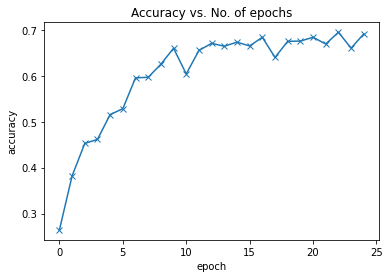

In [55]:
plot_accuracies(val_metrics)

In [56]:
def plot_losses(train_losses, val_losses):
    #train_losses = [x.get('train_losses') for x in history]
    #val_losses = [x['val_losses'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

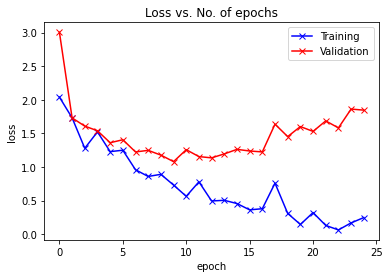

In [57]:
plot_losses(train_losses, val_losses)

In [58]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [59]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, F.cross_entropy, test_loader, accuracy)
result

(1.4717948230743407, 10000, 0.7136)

In [58]:
torch.save(model.state_dict(), 'resnet.pth')